In [1]:
#imports
from PIL import Image
import numpy as np
import os
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
import math
import itertools
import json

# Keras imports
from tqdm import tqdm
from keras.layers import Conv2D, Flatten
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils


#constants
PATH_OF_CSV = './data/trainingdata/set4/driving_log.csv'
# PATH_OF_CSV = 'driving_log.csv'

input_shape = (18, 80, 3)
# 10 degrees = 0.17 radian
steering_correction = 0.17

Using TensorFlow backend.


In [2]:
# read CSV data
def readCsv():
    data = []
    with open(PATH_OF_CSV) as F:
        reader = csv.reader(F)
        for i in reader:
            data.append(i) 
    print('{0} images available in training data'.format(len(data)))
    #print("Imported {0} rows from CSV".format(len(data)))
    return np.array(data)

csvData = readCsv()

8036 images available in training data


In [3]:
### This function will resize the images from front, left and
### right camera to 18 x 80 and turn them into lists.
### The length of the each list will be 18 x 80 = 1440
### j = 0,1,2 corresponds to center, left, right
def load_image(csvRow, jj=0):
    image = plt.imread(csvRow[jj].strip())[65:135:4,0:-1:4,:]
    image_list = image.flatten().tolist()
    image_array = np.reshape(np.array(image_list), newshape=input_shape)
    image_array = image_array / 255 - 0.5
    return image_array




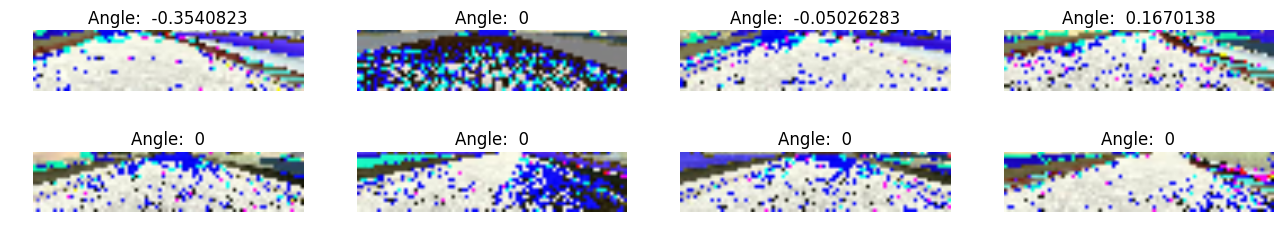

In [4]:
# Plot Images

def getAngleArrayFromCsvData(csvData):
    np_data = np.array(csvData)
    angles = (np_data[:,[3]]).astype('float64')
    angles = np.squeeze(angles, axis=1)
    return angles


# Plot 8 random images
def plotRandomImage(csvData):
    X_random_16 = np.random.choice(len(csvData), 8)
    plt.figure(figsize=(16,6))
    for ii,idx in enumerate(X_random_16):
        #get image
        img = load_image(csvData[idx])
        angle = csvData[idx][3]
        plt.subplot(4,4, ii+1)
        plt.axis('off')
        plt.title('Angle: {}'.format(angle))
        plt.imshow(img)
#         plt.imshow(np.squeeze(img, axis=2))
        
def plotYHistorygram(csvData):
    angles = getAngleArrayFromCsvData(csvData)
    plt.figure()
    hist = plt.hist(angles, bins=51, alpha=0.5)
    plt.title("Histogram with 'auto' bins")
    plt.show()        
    
#display min,max steering and image
def plotMinMax(csvData):
    angle_array = getAngleArrayFromCsvData(csvData)
    y_train_min = np.argmin(angle_array)
    y_train_max = np.argmax(angle_array)
    X_min = load_image(csvData[y_train_min])
    X_max = load_image(csvData[y_train_max])
    plt.figure(figsize=(16,8))
    plt.subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(np.squeeze(X_min, axis=2))
    plt.title('Minimum Angle: {}'.format(angle_array[y_train_min]))
    plt.subplot(1,2, 2)
    plt.axis('off')
    plt.title('Maximum Angle: {}'.format(angle_array[y_train_max]))
    plt.imshow(np.squeeze(X_max, axis=2))

    
    
    
plotRandomImage(csvData)
# plotYHistorygram(csvData)
# plotMinMax(csvData)

In [5]:
## preprocessing functions

def normalize(image_array):
    image_array = image_array / 255 - 0.5
    return image_array


def p_flip(image, steering_angle):
    return np.fliplr(image), -1 * steering_angle

def random_flip(images, steering_angles):
    coin = random.choice(range(0,1))
    if coin == 0:
        features = []
        labels = []
        for image,angle in zip(images, steering_angles):
            image, angle = p_flip(image, angle)
            features.append(image)
            labels.append(angle)
        return  np.array(features), np.array(labels)
    else:
        return images, steering_angles

# test flip
def test_flip(csvData):
    angle_array = getAngleArrayFromCsvData(csvData)
    y_train_max = np.argmax(angle_array)
    X_train_max, Y_train_max = p_flip(load_image(csvData[y_train_max]), angle_array[y_train_max])
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(np.squeeze(load_image(csvData[y_train_max]), axis=2))
    plt.title('Original Angle: {}'.format(angle_array[y_train_max]))
    plt.subplot(1,2, 2)
    plt.axis('off')
    plt.title('Flipped Angle: {}'.format(Y_train_max))
    plt.imshow(np.squeeze(X_train_max, axis=2))

# test_flip(csvData)

In [6]:
# Split CSV Data

#Split the data into training/validation/testing sets here.

CSV_train, CSV_test  = train_test_split(
    csvData,test_size=0.10, random_state=42)

print('Shape of training csv {}', CSV_train.shape)
print('Shape of test csv {}', CSV_test.shape)

#Shuffling training data
CSV_train = shuffle(CSV_train)

Shape of training csv {} (7232, 7)
Shape of test csv {} (804, 7)


In [7]:
# Get randomized datasets for training and validation
CSV_train, CSV_validation = train_test_split(
    CSV_train,
    test_size=0.10,
    random_state=434339)

print('Shape of  train csv {}', CSV_train.shape)
print('Shape of validation csv {}', CSV_validation.shape)

Shape of  train csv {} (6508, 7)
Shape of validation csv {} (724, 7)


In [8]:
## get image for generator
def get_image(csvRow):
    features = ()
    labels = ()
    #0=center, 1 = left, 2 = right
    for j in range(3):
        features += (load_image(csvRow,j),)
        if j == 1:
            #add steering_correction
            labels += (float(csvRow[3]) + steering_correction,)
        elif j == 2:
            labels += (float(csvRow[3]) - steering_correction,)
        else:
            labels += (float(csvRow[3]),)
#     return np.array(features).reshape(3, 18, 80, 3), np.array(labels)
    return np.array(features), np.array(labels)


def get_image_v2(csvRow):
    features = ()
    labels = ()
    j = random.choice(range(0,2))
    features += (load_image(csvRow,j),)
    labels += (float(csvRow[3]),)
    return np.array(features), np.array(labels)


def test_get_image(CSV_train):
    random_idx = np.random.choice(len(csvData), 1)
    csvRow = np.squeeze(csvData[random_idx])
    X, y = get_image(csvRow)
    print(y)

test_get_image(csvData)
    

[-0.05975719  0.11024281 -0.22975719]


In [9]:
# generate for given set of rows
NO_IMAGES = 3
def get_infite_images_generator(csvRows, batch_size=64):
    infiniteCsvRows = itertools.cycle(csvRows)
    counter = 0
    X = []
    y = []    
    while True:
        if (counter >= batch_size):
            counter = 0
            X_x = np.array(X).reshape(NO_IMAGES*len(X), 18, 80, 3)
            y_y = np.array(y).reshape(NO_IMAGES*len(y))
            X = []
            y = []
            yield X_x, y_y
        csvRow = next(infiniteCsvRows)
        features, labels = get_image(np.squeeze(csvRow))
        features, labels = random_flip(features, labels)
        X.append(features.tolist())
        y.append(labels.tolist())
        counter = counter + NO_IMAGES
        
        
def test_generator(csvRows):
    gg = get_infite_images_generator(csvRows)
    X, y = next(gg)
    print(X.shape, y.shape)

test_generator(csvData)


(66, 18, 80, 3) (66,)


In [10]:
# Set the parameters and print out the summary of the model
np.random.seed(1337)  # for reproducibility

N_CLASSES = 1 # The output is a single digit: a steering angle

#input shape
# input_shape = X_train.shape[1:]
input_shape = (18, 80, 3)

# number of convolutional filters to use
nb_filters1 = 16
nb_filters2 = 8
nb_filters3 = 4
nb_filters4 = 2

# size of pooling area for max pooling
pool_size = (2, 2)

# convolution kernel size
kernel_size = (3, 3)

# Initiating the model
model = Sequential()

# Starting with the convolutional layer
# The first layer will turn 1 channel into 16 channels
model.add(Conv2D(nb_filters1, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 16 channels into 8 channels
model.add(Conv2D(nb_filters2, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 8 channels into 4 channels
model.add(Conv2D(nb_filters3, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# The second conv layer will convert 4 channels into 2 channels
model.add(Conv2D(nb_filters4, kernel_size[0], kernel_size[1]))
# Applying ReLU
model.add(Activation('relu'))
# Apply Max Pooling for each 2 x 2 pixels
model.add(MaxPooling2D(pool_size=pool_size))
# Apply dropout of 25%
model.add(Dropout(0.25))

# Flatten the matrix. The input has size of 360
model.add(Flatten())
# Input 360 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Input 16 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Input 16 Output 16
model.add(Dense(16))
# Applying ReLU
model.add(Activation('relu'))
# Apply dropout of 50%
model.add(Dropout(0.5))
# Input 16 Output 1
model.add(Dense(N_CLASSES))

model.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 78, 16)    448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 78, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 76, 8)     1160        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 14, 76, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
BATCH_SIZE = 64 # The lower the better
EPOCHS = 5 # The higher the better


# has to be multiple of batch_size and 3
no_samples_per_epoch = 18150
validation_samples = 320
test_samples = 303

model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['accuracy'])

# create two generators for training and validation
train_gen = get_infite_images_generator(CSV_train,batch_size=64)
validation_gen = get_infite_images_generator(CSV_validation, batch_size=32)
test_gen = get_infite_images_generator(CSV_test, batch_size=32)

### Model training
history = model.fit_generator(train_gen, 
                    nb_epoch=EPOCHS,
                    samples_per_epoch=no_samples_per_epoch,
                    nb_val_samples=validation_samples,
                    validation_data=validation_gen,
                    verbose=1)



Epoch 1/5
18150/18150 [==============================] - 71s - loss: 0.0225 - acc: 0.1806 - val_loss: 0.0140 - val_acc: 0.1788

In [12]:
score = model.evaluate_generator(test_gen, test_samples)
print('Test score:', score[0])
print('Test accuracy:', score[1])


# Save model as json file
json_string = model.to_json()

with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)
    # save weights
    model.save_weights('./model.h5')
    print("Saved")

Test score: 0.0130176158156
Test accuracy: 0.178787884116
Saved
